# 💼 Internship Assignment – DeFi Wallet Credit Scoring

**Applicant**:  **Sarthak Maddi**  
**Role**: **AI Engineer**  
**Date**: **[19/07/2025]**


## 📌 Objective

Build a credit scoring model for DeFi wallets on Aave V2 using ~100K transaction records.  
Assign a score (0–1000) based on user activity like deposit, borrow, repay, and liquidationCall.


## Step 1: Loading the Dataset

As part of this assignment, I started by importing the necessary Python libraries like pandas, numpy, matplotlib, seaborn, and scikit-learn. I then loaded the transaction-level dataset (`user-wallet-transactions.json`) to understand the structure and types of actions performed by each wallet. The first few rows and column names are displayed to get a quick overview of the data.


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [75]:
data = pd.read_json("data/user-wallet-transactions.json")
data.head()

,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,2021-08-17 05:29:26,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,2021-05-20 15:36:53,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,2021-07-24 09:28:33,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,2021-07-31 23:15:18,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,2021-04-19 15:25:07,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


In [76]:
print(data.columns)

Index(['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId',
       'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt',
       'updatedAt'],
      dtype='object')


## Step 2: Feature Engineering

Extracted `amount` from transaction data and computed wallet-level stats like:

- Total transactions
- Counts of actions (deposit, borrow, repay, etc.)
- Total, average, and std of transaction amounts

These features help understand wallet behavior.


In [77]:
data['amount'] = data['actionData'].apply(lambda x: x.get('amount') if isinstance(x, dict) else 0)
data['amount'] = pd.to_numeric(data['amount'], errors='coerce')
wallet_stats = data.groupby('userWallet').agg(
    total_txn=('txHash', 'count'),
    num_deposits=('action', lambda x: (x == 'deposit').sum()),
    num_borrows=('action', lambda x: (x == 'borrow').sum()),
    num_repays=('action', lambda x: (x == 'repay').sum()),
    num_redeems=('action', lambda x: (x == 'redeemUnderlying').sum()),
    num_liquidations=('action', lambda x: (x == 'liquidationCall').sum()),
    total_amount=('amount', 'sum'),
    avg_amount=('amount', 'mean'),
    std_amount=('amount', 'std')
).fillna(0)

wallet_stats.head()

,total_txn,num_deposits,num_borrows,num_repays,num_redeems,num_liquidations,total_amount,avg_amount,std_amount
userWallet,,,,,,,,,
0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,0,0,0,0,2.000000e+09,2.000000e+09,0.000000e+00
0x000000000051d07a4fb3bd10121a343d85818da6,1,1,0,0,0,0,1.450000e+20,1.450000e+20,0.000000e+00
0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,0,0,0,0,5.000000e+15,2.500000e+15,2.121320e+15
0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0,0,0,0,4.835297e+18,2.844292e+17,1.084901e+18
0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,15,4,0,0,1.735192e+23,4.348853e+20,1.684377e+21


### Step 3: Wallet Clustering with Machine Learning

To categorize wallets by behavior, I first standardized all numerical features. Then I applied PCA to reduce dimensions while preserving important patterns. Finally, I used KMeans clustering to group wallets into 5 segments based on their transaction profiles.


In [78]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(wallet_stats)

In [79]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [80]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_pca)
wallet_stats['cluster'] = kmeans.labels_

In [81]:
wallet_stats.head()

,total_txn,num_deposits,num_borrows,num_repays,num_redeems,num_liquidations,total_amount,avg_amount,std_amount,cluster
userWallet,,,,,,,,,,
0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,0,0,0,0,2.000000e+09,2.000000e+09,0.000000e+00,0
0x000000000051d07a4fb3bd10121a343d85818da6,1,1,0,0,0,0,1.450000e+20,1.450000e+20,0.000000e+00,0
0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,0,0,0,0,5.000000e+15,2.500000e+15,2.121320e+15,0
0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0,0,0,0,4.835297e+18,2.844292e+17,1.084901e+18,0
0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,15,4,0,0,1.735192e+23,4.348853e+20,1.684377e+21,4


### Step 6: Mapping Clusters to Credit Scores

We assign credit scores (0–1000) to each cluster based on average liquidation count. Clusters with fewer liquidations are rewarded with higher scores. This score is then mapped back to each wallet.


In [82]:
score_map = {
    0: 200,  # assume worst cluster
    1: 400,
    2: 600,
    3: 800,
    4: 1000  # assume best cluster
}

In [83]:
score_assignment = wallet_stats.groupby('cluster').mean()['num_liquidations'].sort_values().index.tolist()
score_assignment

[0, 1, 2, 3, 4]

In [84]:
cluster_score_map = {cluster: score_map[i*int(len(score_map)/len(score_assignment))] for i, cluster in enumerate(score_assignment)}
cluster_score_map

{0: 200, 1: 400, 2: 600, 3: 800, 4: 1000}

In [85]:
wallet_stats['credit_score'] = wallet_stats['cluster'].map(cluster_score_map)
wallet_stats.head()

,total_txn,num_deposits,num_borrows,num_repays,num_redeems,num_liquidations,total_amount,avg_amount,std_amount,cluster,credit_score
userWallet,,,,,,,,,,,
0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,0,0,0,0,2.000000e+09,2.000000e+09,0.000000e+00,0,200
0x000000000051d07a4fb3bd10121a343d85818da6,1,1,0,0,0,0,1.450000e+20,1.450000e+20,0.000000e+00,0,200
0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,0,0,0,0,5.000000e+15,2.500000e+15,2.121320e+15,0,200
0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0,0,0,0,4.835297e+18,2.844292e+17,1.084901e+18,0,200
0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,15,4,0,0,1.735192e+23,4.348853e+20,1.684377e+21,4,1000


In [86]:
wallet_scores = wallet_stats[['credit_score']]
wallet_scores.head()

,credit_score
userWallet,
0x00000000001accfa9cef68cf5371a23025b6d4b6,200
0x000000000051d07a4fb3bd10121a343d85818da6,200
0x000000000096026fb41fc39f9875d164bd82e2dc,200
0x0000000000e189dd664b9ab08a33c4839953852c,200
0x0000000002032370b971dabd36d72f3e5a7bf1ee,1000


### Step 7: Exporting Results

We export the final credit scores and wallet statistics for further analysis or integration:
- `wallet_credit_scores.csv`: Contains wallet addresses and their assigned credit scores.
- `wallet_cluster_stats.csv`: Includes detailed statistics for each wallet with cluster and score info.


In [87]:
wallet_scores.to_csv("outputs/wallet_credit_scores.csv")
wallet_stats.to_csv("outputs/wallet_cluster_stats.csv")

### Extra Step: Visualizing Credit Score Distribution

We plot the distribution of credit scores to understand how wallets are scored across the 0–1000 range. This helps identify the density of low-risk vs. high-risk wallets.


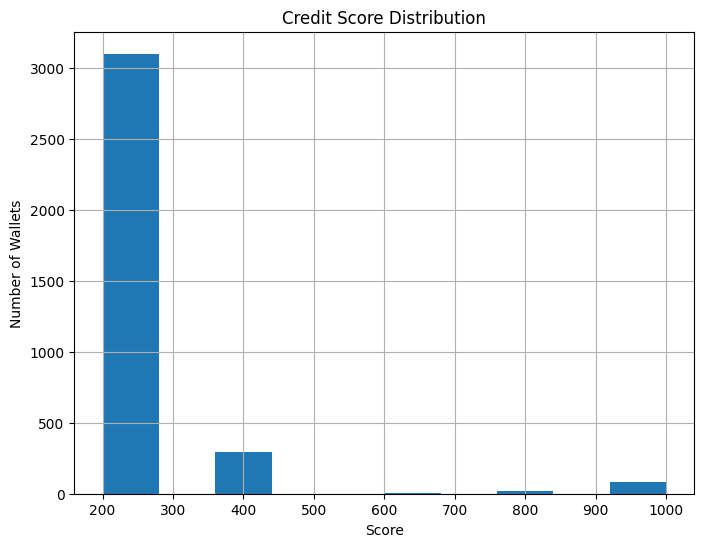

In [88]:
plt.figure(figsize=(8, 6))
wallet_scores['credit_score'].hist(bins=10)
plt.title("Credit Score Distribution")
plt.xlabel("Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.savefig("outputs/score_distribution.png")
plt.show()